# Predicting neighborhoods with exclusively high risk of credit card fraud
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction](#introduction)
* [Data](#Data)
* [Building classification model](#modeling)
* [Model evaluation](#model_evaluation)
* [Result and discussion](#result)
* [Future work](#future)




## Introduction <a name="introduction"></a>

<b>Background:</b>
As economy grow and online payment become prevailing, <b>credit card fraud</b> also finds its way to expand. <b>Theft by use of or counterfeit of credit card</b>, for example, are very common forms of credit card fraud. However, instead of a one-sided game, markets around the world also find their way to fight back. Unfortunately, the winning in some countries leads to the misfortune of their surrounding countries as the case in Europe. According to [the report of FICO (a company providing card alert service) in 2017](https://www.fico.com/europeanfraud/), drop in the successful fraud rate in UK and France has possibly led to the rise of success fraud rates in Austria, Denmark, Norway, Sweden, Poland and Russia. Therefore, capability to predict the neighborhoods with high risk of credit card fraud should be very helpful for financial industries and government of these vulnerable countries to fight against the upcoming fraud.

<b>Problem:</b>
Primary venues of a neighborhood might have great influence on the risk of credit card fraud. For example, neighborhoods with many financial facilities or shopping places could be fraudsters’ favorite spots. Therefore, here we aim to build a model to <b>predict the risk of credit card fraud of neighborhoods</b> based on data of venues scraped from the <b>Foursquare API</b>. In this project, we will train the model with <b>San Francisco data</b>, and evaluate the model performance with <b>Chicago data</b>.

<b>Interest:</b>
Successfully predicting the neighborhoods with high risk of credit card fraud could help local government get prepared in advance to protect citizen from the risk. For financial institutions, they could invest more effort in monitoring transactions within the neighborhoods of exclusively high risk to enhance their efficiency of detecting credit card fraud.

## Data <a name="data"></a>

In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

First, we download the crime data from a year ago to present of SanFrancisco and Chicago.

In [4]:
!wget -q -O 'Sanfran_Crime.csv' https://data.sfgov.org/api/views/tmnf-yvry/rows.csv?accessType=DOWNLOAD
!wget -q -O 'Chicago_Crime.csv' https://data.cityofchicago.org/api/views/x2n5-8w5q/rows.csv?accessType=DOWNLOAD

Let's take a look of the dimension of the two datasets.

In [2]:
Sanfran_Crime_df = pd.read_csv('Sanfran_Crime.csv')
Chicago_Crime_df = pd.read_csv('Chicago_Crime.csv')
print(Sanfran_Crime_df.shape)
print(Chicago_Crime_df.shape)

(2215024, 13)
(264726, 17)


Let's filter out the columns we don't need.

In [5]:
Sanfran_Crime_df = Sanfran_Crime_df[['Category','Descript','Y', 'X']]
Chicago_Crime_df = Chicago_Crime_df[[' PRIMARY DESCRIPTION',' SECONDARY DESCRIPTION','LATITUDE', 'LONGITUDE']]

In [6]:
# rename the columns
Sanfran_Crime_df.columns = ['Category','Description','Latitude','Longitude']
Chicago_Crime_df.columns = ['Category','Description','Latitude','Longitude']

In [18]:
print(Sanfran_Crime_df['Category'].unique())
print(Chicago_Crime_df['Category'].unique())

['NON-CRIMINAL' 'ROBBERY' 'ASSAULT' 'SECONDARY CODES' 'VANDALISM'
 'BURGLARY' 'LARCENY/THEFT' 'DRUG/NARCOTIC' 'WARRANTS' 'VEHICLE THEFT'
 'OTHER OFFENSES' 'WEAPON LAWS' 'ARSON' 'MISSING PERSON'
 'DRIVING UNDER THE INFLUENCE' 'SUSPICIOUS OCC' 'RECOVERED VEHICLE'
 'DRUNKENNESS' 'TRESPASS' 'FRAUD' 'DISORDERLY CONDUCT'
 'SEX OFFENSES, FORCIBLE' 'FORGERY/COUNTERFEITING' 'KIDNAPPING'
 'EMBEZZLEMENT' 'STOLEN PROPERTY' 'LIQUOR LAWS' 'FAMILY OFFENSES'
 'LOITERING' 'BAD CHECKS' 'TREA' 'GAMBLING' 'RUNAWAY' 'BRIBERY'
 'PROSTITUTION' 'PORNOGRAPHY/OBSCENE MAT' 'SEX OFFENSES, NON FORCIBLE'
 'SUICIDE' 'EXTORTION']
['NARCOTICS' 'BATTERY' 'CRIMINAL DAMAGE' 'THEFT' 'ARSON' 'OTHER OFFENSE'
 'ROBBERY' 'CRIMINAL TRESPASS' 'OFFENSE INVOLVING CHILDREN' 'BURGLARY'
 'WEAPONS VIOLATION' 'DECEPTIVE PRACTICE' 'ASSAULT' 'MOTOR VEHICLE THEFT'
 'CRIM SEXUAL ASSAULT' 'INTERFERENCE WITH PUBLIC OFFICER' 'NON-CRIMINAL'
 'HOMICIDE' 'PROSTITUTION' 'SEX OFFENSE' 'PUBLIC PEACE VIOLATION'
 'GAMBLING' 'INTIMIDATION' 'LIQUOR LA

We found category 'FRAUD' in Sanfran_Crime_df and 'DECEPTIVE PRACTICE' in Chicago_Crime_df might be relevant to the cards' fraud. So we take a further look into their descriptions.

In [117]:
print(Sanfran_Crime_df['Description'][Sanfran_Crime_df['Category']=='FRAUD'].unique())
print(Chicago_Crime_df['Description'][Chicago_Crime_df['Category']=='DECEPTIVE PRACTICE'].unique())
San_fraud = Sanfran_Crime_df['Description'][Sanfran_Crime_df['Category']=='FRAUD'].unique()
Chi_fraud = Chicago_Crime_df['Description'][Chicago_Crime_df['Category']=='DECEPTIVE PRACTICE'].unique()

['CREDIT CARD, THEFT BY USE OF' 'DEFRAUDING AN INNKEEPER'
 'FRAUDULENT USE OF AUTOMATED TELLER CARD' 'FALSE PRETENSES, GRAND THEFT'
 'CREDIT CARD, THEFT OF' 'FALSE ID TO PEACE OFFICER'
 'FALSE PRETENSES, PETTY THEFT' 'FALSE REPORT OF EMERGENCY'
 'FRAUDULENT CREDIT APPLICATION' 'TRICK AND DEVICE, PETTY THEFT'
 'FORGERY, CREDIT CARD' 'ACCESS CARD INFORMATION, THEFT OF'
 'CREDIT CARD, INCOMPLETE OR COUNTERFEIT' 'IMPERSONATING A POLICE OFFICER'
 'PRIVACY, INVASION OF  (GENERAL)' 'TRICK AND DEVICE, GRAND THEFT'
 'REAL ESTATE FRAUD'
 'CELLULAR OR CORDLESS PHONE COMMUNICATIONS, INTERCEPTING'
 'FALSE CLAIMS, PRESENTING TO GOVERNMENT' 'TRICK AND DEVICE, ATTEMPTED'
 'DEFRAUDING OF VEHICLE REPAIRMAN'
 'ACCESS CARD INFORMATION, PUBLICATION OF'
 'CRIMES AGAINST REVENUE & PROPERTY OF STATE'
 'TELEPHONE OR TELEGRAPH MESSAGES, ALTERING'
 'IMPERSONATING PUBLIC UTILITY MEMBER'
 'FALSE REPRESENTATION TO SECONDHAND DEALER'
 'AUDIOVISUAL (VIDEO OR SOUND) RECORDINGS, UNAUTHORIZED'
 'IMPERSONATING FIRE DEPAR

Now let's narrow down our data to cards' fraud according to the descriptions. The according descriptions in San Francisco data is <b>'CREDIT CARD, THEFT BY USE OF', 'CREDIT CARD, THEFT OF'</b>. And the according descriptions in Chicago data is <b>'CREDIT CARD FRAUD'</b>.

In [7]:
Cards_San = ['CREDIT CARD, THEFT BY USE OF', 'CREDIT CARD, THEFT OF']
Cards_Chi = ['CREDIT CARD FRAUD']

# create empty dataframe to append the rows we need by loop
San_Cards_Fraud = pd.DataFrame(columns=['Category','Description','Latitude','Longitude'])
Chi_Cards_Fraud = pd.DataFrame(columns=['Category','Description','Latitude','Longitude'])

# loop through the original data to extract the rows of cards' fraud
for cards in Cards_San:
    San_Cards_Fraud=San_Cards_Fraud.append(Sanfran_Crime_df[Sanfran_Crime_df['Description'] == cards], ignore_index = True)

for cards in Cards_Chi:
    Chi_Cards_Fraud=Chi_Cards_Fraud.append(Chicago_Crime_df[Chicago_Crime_df['Description'] == cards], ignore_index = True)
    
print(San_Cards_Fraud.shape)
print(Chi_Cards_Fraud.shape)

(23083, 4)
(4678, 4)


For the San Francisco data we use the <b>within()</b> method in the shapely library to help us find out the neighborhood that each card's fraud happened. Here we use the analysis neighborhoods of San Francisco from https://data.sfgov.org/Geographic-Locations-and-Boundaries/Analysis-Neighborhoods/p5b7-5n3h, which were defined for the purpose of providing consistency in the analysis and reporting of socio-economic, demographic, and environmental data, and data on City-funded programs and services. 

In [11]:
San_Cards_Fraud.head()

,Category,Description,Latitude,Longitude
0,FRAUD,"CREDIT CARD, THEFT BY USE OF",37.791178,-122.400749
1,FRAUD,"CREDIT CARD, THEFT BY USE OF",37.799209,-122.433407
2,FRAUD,"CREDIT CARD, THEFT BY USE OF",37.729935,-122.397744
3,FRAUD,"CREDIT CARD, THEFT BY USE OF",37.789173,-122.409445
4,FRAUD,"CREDIT CARD, THEFT BY USE OF",37.802120,-122.425559


In [4]:
!conda install -c conda-forge shapely --yes

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs:
    - shapely


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    basemap-1.2.0              |   py36h673bf1a_2        15.2 MB  conda-forge
    geos-3.7.1                 |    hf484d3e_1000         1.6 MB  conda-forge
    shapely-1.6.4              |py36h2afed24_1003         337 KB  conda-forge
    ------------------------------------------------------------
                                           Total:        17.1 MB

The following NEW packages will be INSTALLED:

  shapely            conda-forge/linux-64::shapely-1.6.4-py36h2afed24_1003

The following packages will be UPDATED:

  basemap            anaconda::basemap-1.2.0-py36h705c2d8_0 --> conda-forge::basemap-1.2.0-py36h673bf1a_2
  geos                     pkgs/main::geos-3.6.2-heeff764_2 --> conda-forge::geos-3.7

In [6]:
import shapely
import shapefile
import json
from shapely.geometry import LineString, shape, Point
with open('Analysis_Neighborhoods.geojson') as geojson_data:
    Analysis_Neighborhoods = json.load(geojson_data)

In [13]:
Lat = San_Cards_Fraud['Latitude']
Lon = San_Cards_Fraud['Longitude']
Neighborhood = list(np.zeros_like(San_Cards_Fraud['Latitude'])) # in case there's any incident located out of all neighborhoods

for i in range(San_Cards_Fraud.shape[0]):
    point = Point(Lon[i], Lat[i])
    #loop through neighborhoods to see whether the coordinate is wtihin it
    for k in range(len(Analysis_Neighborhoods['features'])):
        multi = shape(Analysis_Neighborhoods['features'][k]['geometry'])      
        if point.within(multi):
            Neighborhood[i] = Analysis_Neighborhoods['features'][k]['properties']['nhood']
            break

Neighborhood[0:10]

['Financial District/South Beach',
 'Marina',
 'Bayview Hunters Point',
 'Nob Hill',
 'Marina',
 'North Beach',
 'Mission',
 'Tenderloin',
 'Nob Hill',
 'Western Addition']

In [14]:
San_Cards_Fraud['Neighborhood']=Neighborhood
# drop rows that don't belong to any neighborhood
San_Cards_Fraud['Neighborhood'].replace(0, np.nan, inplace=True)
San_Cards_Fraud.dropna(subset=["Neighborhood"], axis=0, inplace=True)

# reset index, because we droped two rows
San_Cards_Fraud.reset_index(drop=True, inplace=True)

In [15]:
San_Cards_Fraud.shape

(23068, 5)

For Chicago data, we found some functions on GitHub that can assigned neighborhood to a given coordinate. So we just used the code directly. To successfully use it, we need to download the gps_to_neighborhood.py and Neighborhoods_2012_polygons file to the working directory from https://github.com/jkgiesler/parse-chicago-neighborhoods.

In [8]:
import gps_to_neighborhood

NEAR SOUTH SIDE


In [9]:
# drop whole row that don't have coordinates
Chi_Cards_Fraud.dropna(subset=["Latitude"], axis=0, inplace=True)
# reset index
Chi_Cards_Fraud.reset_index(drop=True, inplace=True)

all_neighborhoods = gps_to_neighborhood.get_all_neighborhoods()
Neighborhoods = np.zeros_like(Chi_Cards_Fraud.iloc[:,0])
for i in range(Chi_Cards_Fraud.shape[0]):
    Neighborhoods[i] = gps_to_neighborhood.find_neighborhood(Chi_Cards_Fraud['Longitude'][i],Chi_Cards_Fraud['Latitude'][i],all_neighborhoods)

In [10]:
Chi_Cards_Fraud['Neighborhood']=Neighborhoods[:]
Chi_Cards_Fraud.head()

,Category,Description,Latitude,Longitude,Neighborhood
0,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,41.891199,-87.624138,STREETERVILLE
1,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,41.881718,-87.627760,LOOP
2,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,41.896561,-87.636585,RIVER NORTH
3,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,41.750060,-87.702402,ASHBURN
4,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,41.911780,-87.677494,"WICKER PARK,WEST TOWN"


In [16]:
San_Cards_Fraud.to_csv('San_Cards_Frauds_copy.csv')
Chi_Cards_Fraud.to_csv('Chi_Cards_Frauds_copy.csv')

In [7]:
San_Cards_Fraud = pd.read_csv('San_Cards_Frauds_copy.csv').iloc[:,1:6]
Chi_Cards_Fraud = pd.read_csv('Chi_Cards_Frauds_copy.csv').iloc[:,1:6]

### Credit card fraud rates of neighborhoods in San Francisco

In [8]:
#calculate credit card fraud rates of each nieghborhood
Counts = San_Cards_Fraud.groupby('Neighborhood').count()['Category']
San_Cards_Fraud_rates = San_Cards_Fraud.groupby('Neighborhood').count()
San_Cards_Fraud_rates['Rates (%)'] = Counts*100/sum(Counts)
San_Cards_Fraud_rates.drop(['Category','Description','Latitude','Longitude'], axis=1, inplace=True)
San_Cards_Fraud_rates = San_Cards_Fraud_rates.reset_index()
San_Cards_Fraud_rates

,Neighborhood,Rates (%)
0,Bayview Hunters Point,2.657361
1,Bernal Heights,1.452228
2,Castro/Upper Market,3.676088
3,Chinatown,2.115485
4,Excelsior,1.512918
5,Financial District/South Beach,11.613491
6,Glen Park,0.611236
7,Golden Gate Park,0.481186
8,Haight Ashbury,1.747009
9,Hayes Valley,2.466620


In [9]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.0.3


Let's draw a boxplot to see the distribution of credit card fraud rates of neighborhoods.

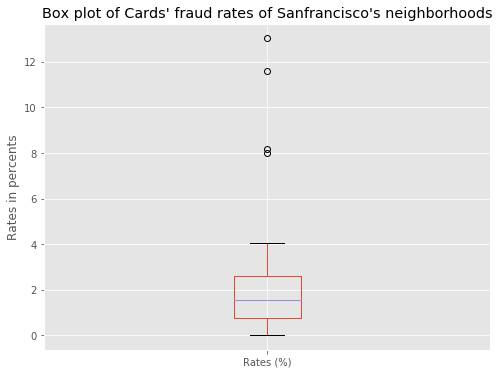

In [10]:
San_Cards_Fraud_rates['Rates (%)'].plot(kind='box', figsize=(8, 6))

plt.title("Box plot of Cards' fraud rates of Sanfrancisco's neighborhoods")
plt.ylabel('Rates in percents')

plt.show()

In [10]:
# Descriptive statistics for credit card fraud rates of neighborhoods
Descriptive = San_Cards_Fraud_rates['Rates (%)'].describe()
Descriptive

count    41.000000
mean      2.439024
std       2.879823
min       0.013005
25%       0.758627
50%       1.538928
75%       2.618346
max      13.026704
Name: Rates (%), dtype: float64

From the boxplot, indeed,we saw there're some outliers with exclusively high credit card fraud rates. Thus, we labeled the neighborhoods into two categories which are average (not outliers) and outliers (over 75 quantile + 1.5 IQR).

In [11]:
rates = San_Cards_Fraud_rates['Rates (%)']
risk_level = list(np.zeros_like(rates))
San_Cards_Fraud_rates['risk_level'] = risk_level
IQR = Descriptive['75%']-Descriptive['25%']
San_Cards_Fraud_rates['risk_level'][rates <= Descriptive['75%']+1.5*IQR] = 'average'
San_Cards_Fraud_rates['risk_level'][rates > Descriptive['75%']+1.5*IQR] = 'outliers'

San_Cards_Fraud_rates.head()

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Neighborhood,Rates (%),risk_level
0,Bayview Hunters Point,2.657361,average
1,Bernal Heights,1.452228,average
2,Castro/Upper Market,3.676088,average
3,Chinatown,2.115485,average
4,Excelsior,1.512918,average


To obtain the popular venues of each neighborhood, we need to acquire the coordinates of their centroids.

In [12]:
Lat = []
Lon = []

for i in range(San_Cards_Fraud_rates.shape[0]):
    # get the centroid of each neighborhood's polygon
    for k in range(len(Analysis_Neighborhoods['features'])):
        multi = shape(Analysis_Neighborhoods['features'][k]['geometry'])
        # match each neighborhood with their polygon
        if San_Cards_Fraud_rates['Neighborhood'][i]==Analysis_Neighborhoods['features'][k]['properties']['nhood']:
            Lat.append(multi.centroid.y)
            Lon.append(multi.centroid.x)
            
San_Cards_Fraud_rates['Latitude']=Lat
San_Cards_Fraud_rates['Longitude']=Lon
San_Cards_Fraud_rates.head()

,Neighborhood,Rates (%),risk_level,Latitude,Longitude
0,Bayview Hunters Point,2.657361,average,37.730889,-122.386016
1,Bernal Heights,1.452228,average,37.740364,-122.415664
2,Castro/Upper Market,3.676088,average,37.762319,-122.435217
3,Chinatown,2.115485,average,37.796140,-122.407081
4,Excelsior,1.512918,average,37.718562,-122.431807


We can also draw a choropleth of cards' fraud rates in San Francisco to see the difference.

In [18]:
import folium

latitude = 37.77
longitude = -122.42

# create a plain world map
Fraud_map = folium.Map(location=[latitude, longitude], zoom_start=12)

Fraud_map.choropleth(
    geo_data=Analysis_Neighborhoods,
    data=San_Cards_Fraud_rates,
    columns=['Neighborhood', 'Rates (%)'],
    key_on='feature.properties.nhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name="Cards Fraud Rates in San Francisco"
)

# display map
Fraud_map.save('Map.html')
from IPython.display import IFrame
IFrame('Map.html', width='100%', height='750px')

### Credit card fraud rates of neighborhoods in Chicago

In [13]:
# load the json file of Chicago's neighborhoods
with open('Neighborhoods_2012_polygons.json') as json_data:
    Chicago_Neighborhoods = json.load(json_data)

In [14]:
#calculate credit card fraud rates of each nieghborhood
Counts = Chi_Cards_Fraud.groupby('Neighborhood').count()['Category']
Chi_Cards_Fraud_rates = Chi_Cards_Fraud.groupby('Neighborhood').count()
Chi_Cards_Fraud_rates['Rates (%)'] = Counts*100/sum(Counts)
Chi_Cards_Fraud_rates.drop(['Category','Description','Latitude','Longitude'], axis=1, inplace=True)
Chi_Cards_Fraud_rates = Chi_Cards_Fraud_rates.reset_index()
print(Chi_Cards_Fraud_rates.shape)
Chi_Cards_Fraud_rates

(76, 2)


,Neighborhood,Rates (%)
0,ANDERSONVILLE,0.256231
1,"ARCHER HEIGHTS,WEST ELSDON",0.419287
2,"ARMOUR SQUARE,CHINATOWN",0.419287
3,ASHBURN,0.722106
4,AUBURN GRESHAM,1.118099
5,AUSTIN,2.003261
6,"AVALON PARK,CALUMET HEIGHTS",0.628931
7,BACK OF THE YARDS,0.768693
8,"BELMONT CRAGIN,HERMOSA",0.652225
9,"BELMONT CRAIGIN,HERMOSA",0.209644


There are only 76 neighborhoods with cards' fraud data, however there are 78 neighborhoods in Chicago according to the json file. Therefore, we need to append the missing neighborhoods and set their cards' fraud rates to zero.

In [15]:
for i in range(len(Chicago_Neighborhoods['features'])):
    if Chicago_Neighborhoods['features'][i]['properties']['SEC_NEIGH'] not in list(Chi_Cards_Fraud_rates['Neighborhood']):
        Chi_Cards_Fraud_rates = Chi_Cards_Fraud_rates.append({'Neighborhood':Chicago_Neighborhoods['features'][i]['properties']['SEC_NEIGH'], 'Rates (%)':0},
                                                             ignore_index=True)

In [16]:
Chi_Cards_Fraud_rates.shape

(78, 2)

Let's draw a boxplot to see the distribution of credit card fraud rates of neighborhoods.

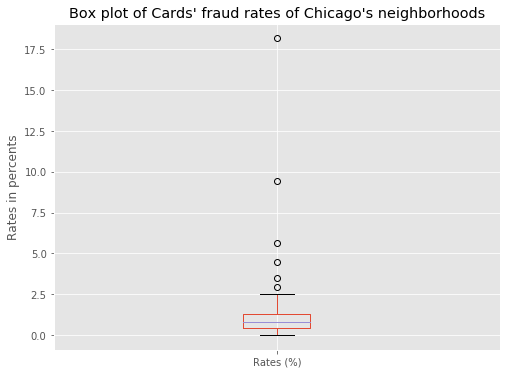

In [23]:
Chi_Cards_Fraud_rates['Rates (%)'].plot(kind='box', figsize=(8, 6))

plt.title("Box plot of Cards' fraud rates of Chicago's neighborhoods")
plt.ylabel('Rates in percents')

plt.show()

In [17]:
# Descriptive statistics for credit card fraud rates of neighborhoods
Descriptive = Chi_Cards_Fraud_rates['Rates (%)'].describe()
Descriptive

count    78.000000
mean      1.282051
std       2.362805
min       0.000000
25%       0.401817
50%       0.768693
75%       1.269509
max      18.169113
Name: Rates (%), dtype: float64

Again, we saw there're some outliers with exclusively high credit card fraud rates. Thus, we labeled the neighborhoods into two categories which are average (not outliers) and outliers (over 75 quantile + 1.5 IQR).

In [18]:
rates = Chi_Cards_Fraud_rates['Rates (%)']
risk_level = list(np.zeros_like(rates))
Chi_Cards_Fraud_rates['risk_level'] = risk_level
IQR = Descriptive['75%']-Descriptive['25%']
Chi_Cards_Fraud_rates['risk_level'][rates <= Descriptive['75%']+1.5*IQR] = 'average'
Chi_Cards_Fraud_rates['risk_level'][rates > Descriptive['75%']+1.5*IQR] = 'outliers'

Chi_Cards_Fraud_rates.head()

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Neighborhood,Rates (%),risk_level
0,ANDERSONVILLE,0.256231,average
1,"ARCHER HEIGHTS,WEST ELSDON",0.419287,average
2,"ARMOUR SQUARE,CHINATOWN",0.419287,average
3,ASHBURN,0.722106,average
4,AUBURN GRESHAM,1.118099,average


To obtain the popular venues of each neighborhood, we need to acquire the coordinates of their centroids.

In [19]:
Lat = []
Lon = []

for i in range(Chi_Cards_Fraud_rates.shape[0]):
    # get the centroid of each neighborhood's polygon
    for k in range(len(Chicago_Neighborhoods['features'])):
        multi = shape(Chicago_Neighborhoods['features'][k]['geometry'])
        # match each neighborhood with their polygon
        if Chi_Cards_Fraud_rates['Neighborhood'][i]==Chicago_Neighborhoods['features'][k]['properties']['SEC_NEIGH']:
            Lat.append(multi.centroid.y)
            Lon.append(multi.centroid.x)
            break
            
Chi_Cards_Fraud_rates['Latitude']=Lat
Chi_Cards_Fraud_rates['Longitude']=Lon
Chi_Cards_Fraud_rates.head()

,Neighborhood,Rates (%),risk_level,Latitude,Longitude
0,ANDERSONVILLE,0.256231,average,41.979854,-87.667865
1,"ARCHER HEIGHTS,WEST ELSDON",0.419287,average,41.810880,-87.726363
2,"ARMOUR SQUARE,CHINATOWN",0.419287,average,41.836091,-87.633222
3,ASHBURN,0.722106,average,41.745757,-87.708365
4,AUBURN GRESHAM,1.118099,average,41.744205,-87.656307


### Scraping data of popular venues from Foursquare API

In [20]:
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

Define Foursquare Credentials and Version

In [16]:
CLIENT_ID = 'W5MC3D2YN3TRKIYR3DYNSETNTWM3NB54OXFRMCBJ2PHSV1F1' # your Foursquare ID
CLIENT_SECRET = 'DEXOA5GGMPUONILBNDMNXZEKF4AMWOX5YA4ZSPJRSUQ4BHW1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: W5MC3D2YN3TRKIYR3DYNSETNTWM3NB54OXFRMCBJ2PHSV1F1
CLIENT_SECRET:DEXOA5GGMPUONILBNDMNXZEKF4AMWOX5YA4ZSPJRSUQ4BHW1


From the Foursquare lab in the previous module, we know that all the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [18]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Let's create a function to repeat the process exploring each neighborhood

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### San Francisco data as training set

Now write the code to run the above function on each neighborhood and create a new dataframe called *SanFran_venues*.

In [20]:
SanFran_venues = getNearbyVenues(names=San_Cards_Fraud_rates['Neighborhood'],
                                   latitudes=San_Cards_Fraud_rates['Latitude'],
                                   longitudes=San_Cards_Fraud_rates['Longitude']
                                  )

Bayview Hunters Point
Bernal Heights
Castro/Upper Market
Chinatown
Excelsior
Financial District/South Beach
Glen Park
Golden Gate Park
Haight Ashbury
Hayes Valley
Inner Richmond
Inner Sunset
Japantown
Lakeshore
Lincoln Park
Lone Mountain/USF
Marina
McLaren Park
Mission
Mission Bay
Nob Hill
Noe Valley
North Beach
Oceanview/Merced/Ingleside
Outer Mission
Outer Richmond
Pacific Heights
Portola
Potrero Hill
Presidio
Presidio Heights
Russian Hill
Seacliff
South of Market
Sunset/Parkside
Tenderloin
Treasure Island
Twin Peaks
Visitacion Valley
West of Twin Peaks
Western Addition


In [21]:
# save the work
SanFran_venues.to_csv('SanFran_venues.csv')

In [27]:
SanFran_venues = pd.read_csv('SanFran_venues.csv')

To better illustrate the model results and build a more general model, we look up the primary category of each category. We find the text file of categorytree of Foursquare API on GitHub and use it to look up primary categories.

In [28]:
# read the txt file into list
f = open('4sq_category_tree.txt', 'r')
lines = f.readlines()

## get list of primary categories
primary = []
# primary categories don't have space at the beginning
for i in lines:
    split_list = i.split(" ")
    if split_list[0] != "":
        primary.append(i)
print(primary)  # we found there are ten primary categories

## segment the category list by primary categories
Arts_and_Entertainment = lines[lines.index('Arts & Entertainment\n'):lines.index('College & University\n')]    
College_and_University = lines[lines.index('College & University\n'):lines.index('Event\n')]
Event = lines[lines.index('Event\n'):lines.index('Food\n')]
Food = lines[lines.index('Food\n'):lines.index('Nightlife Spot\n')]
Nightlife_Spot = lines[lines.index('Nightlife Spot\n'):lines.index('Outdoors & Recreation\n')]
Outdoors_and_Recreation = lines[lines.index('Outdoors & Recreation\n'):lines.index('Professional & Other Places\n')]
Professional_and_Other_Places = lines[lines.index('Professional & Other Places\n'):lines.index('Residence\n')]
Residence = lines[lines.index('Residence\n'):lines.index('Shop & Service\n')]
Shop_and_Service = lines[lines.index('Shop & Service\n'):lines.index('Travel & Transport\n')]
Travel_and_Transport = lines[lines.index('Travel & Transport\n'):]

['Arts & Entertainment\n', 'College & University\n', 'Event\n', 'Food\n', 'Nightlife Spot\n', 'Outdoors & Recreation\n', 'Professional & Other Places\n', 'Residence\n', 'Shop & Service\n', 'Travel & Transport\n']


In [29]:
# function that get primary categories of the subcategories
def get_primary_category(category_list):
    primary_category = []
    k = 0
    for category in category_list:
        for i in range(len(Arts_and_Entertainment)):
            if len(primary_category) > k:    # if the primary category was found then break the loop
                break
            if category in Arts_and_Entertainment[i][-(len(category)+2):]:
                primary_category.append('Arts_and_Entertainment')
                break
                
        for i in range(len(College_and_University)):
            if len(primary_category) > k:    # if the primary category was found then break the loop
                break
            if category in College_and_University[i][-(len(category)+2):]:
                primary_category.append('College_and_University')
                break
                
        for i in range(len(Event)):
            if len(primary_category) > k:    # if the primary category was found then break the loop
                break
            if category in Event[i][-(len(category)+2):]:
                primary_category.append('Event')
                break
                
        for i in range(len(Food)):
            if len(primary_category) > k:    # if the primary category was found then break the loop
                break
            if category in Food[i][-(len(category)+2):]:
                primary_category.append('Food')
                break
                
        for i in range(len(Nightlife_Spot)):
            if len(primary_category) > k:    # if the primary category was found then break the loop
                break
            if category in Nightlife_Spot[i][-(len(category)+2):]:
                primary_category.append('Nightlife_Spot')
                break
                
        for i in range(len(Outdoors_and_Recreation)):
            if len(primary_category) > k:    # if the primary category was found then break the loop
                break
            if category in Outdoors_and_Recreation[i][-(len(category)+2):]:
                primary_category.append('Outdoors_and_Recreation')
                break
                
        for i in range(len(Professional_and_Other_Places)):
            if len(primary_category) > k:    # if the primary category was found then break the loop
                break
            if category in Professional_and_Other_Places[i][-(len(category)+2):]:
                primary_category.append('Professional_and_Other_Places')
                break
                
        for i in range(len(Residence)):
            if len(primary_category) > k:    # if the primary category was found then break the loop
                break
            if category in Residence[i][-(len(category)+2):]:
                primary_category.append('Residence')
                break
                
        for i in range(len(Shop_and_Service)):
            if len(primary_category) > k:    # if the primary category was found then break the loop
                break
            if category in Shop_and_Service[i][-(len(category)+2):]:
                primary_category.append('Shop_and_Service')
                break
                
        for i in range(len(Travel_and_Transport)):
            if len(primary_category) > k:    # if the primary category was found then break the loop
                break
            if category in Travel_and_Transport[i][-(len(category)+2):]:
                primary_category.append('Travel_and_Transport')
                break
        
        # if category doesn't belong to any of them, we append nan to the list 
        k = k+1
        if len(primary_category) < k:
            primary_category.append(np.nan)
        
    return primary_category

In [30]:
#replace the subcategories by primary categories
SanFran_venues['Venue Category'] = get_primary_category(SanFran_venues['Venue Category'])
SanFran_venues.shape

(1858, 8)

In [31]:
#remove rows those primary categories were not found
SanFran_venues.dropna(subset=["Venue Category"], axis=0, inplace=True)
SanFran_venues.shape

(1826, 8)

In [24]:
# one hot encoding
SanFran_onehot = pd.get_dummies(SanFran_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
SanFran_onehot['Neighborhoods'] = SanFran_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [SanFran_onehot.columns[-1]] + list(SanFran_onehot.columns[:-1])
SanFran_onehot = SanFran_onehot[fixed_columns]

SanFran_onehot.head()

,Neighborhoods,Arts_and_Entertainment,College_and_University,Food,Nightlife_Spot,Outdoors_and_Recreation,Professional_and_Other_Places,Shop_and_Service,Travel_and_Transport
0,Bayview Hunters Point,0,1,0,0,0,0,0,0
1,Bayview Hunters Point,1,0,0,0,0,0,0,0
2,Bayview Hunters Point,0,0,0,0,0,0,1,0
3,Bayview Hunters Point,0,0,0,0,1,0,0,0
4,Bernal Heights,0,0,1,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [25]:
SanFran_grouped = SanFran_onehot.groupby('Neighborhoods').mean().reset_index()
SanFran_grouped.head()

,Neighborhoods,Arts_and_Entertainment,College_and_University,Food,Nightlife_Spot,Outdoors_and_Recreation,Professional_and_Other_Places,Shop_and_Service,Travel_and_Transport
0,Bayview Hunters Point,0.250000,0.250000,0.000000,0.000000,0.250000,0.00,0.250000,0.000000
1,Bernal Heights,0.028571,0.028571,0.514286,0.057143,0.057143,0.00,0.257143,0.057143
2,Castro/Upper Market,0.070707,0.030303,0.424242,0.141414,0.030303,0.00,0.292929,0.010101
3,Chinatown,0.030000,0.020000,0.680000,0.110000,0.020000,0.02,0.110000,0.010000
4,Excelsior,0.000000,0.250000,0.000000,0.000000,0.750000,0.00,0.000000,0.000000


We found that their was no venues of 'Residence' and 'Event' found in SanFrancisco neighborhoods. For the general applicability of the model, we add the two column with values of zero.

In [26]:
SanFran_grouped['Residence'] = np.zeros_like(SanFran_grouped['Food'])
SanFran_grouped['Event'] = np.zeros_like(SanFran_grouped['Food'])
SanFran_grouped.head()

,Neighborhoods,Arts_and_Entertainment,College_and_University,Food,Nightlife_Spot,Outdoors_and_Recreation,Professional_and_Other_Places,Shop_and_Service,Travel_and_Transport,Residence,Event
0,Bayview Hunters Point,0.250000,0.250000,0.000000,0.000000,0.250000,0.00,0.250000,0.000000,0.0,0.0
1,Bernal Heights,0.028571,0.028571,0.514286,0.057143,0.057143,0.00,0.257143,0.057143,0.0,0.0
2,Castro/Upper Market,0.070707,0.030303,0.424242,0.141414,0.030303,0.00,0.292929,0.010101,0.0,0.0
3,Chinatown,0.030000,0.020000,0.680000,0.110000,0.020000,0.02,0.110000,0.010000,0.0,0.0
4,Excelsior,0.000000,0.250000,0.000000,0.000000,0.750000,0.00,0.000000,0.000000,0.0,0.0


In [ ]:
X = SanFran_grouped.iloc[:,1:]
X.head()

Since the data of popular venues could vary from time to time, to make sure we have consistent output, I save the X metrics on cloud and use pd.read_csv to read it when it's needed.

In [20]:
X = pd.read_csv('https://query.data.world/s/i4yjnhkwht5pg3j4cgkxdu4lvx2eym').iloc[:,1:]
print(X.head())
y = San_Cards_Fraud_rates['risk_level']
y[0:5]

   Arts_and_Entertainment  College_and_University      Food  Nightlife_Spot  \
0                0.250000                0.250000  0.000000        0.000000   
1                0.028571                0.028571  0.514286        0.057143   
2                0.070707                0.030303  0.424242        0.141414   
3                0.030000                0.020000  0.680000        0.110000   
4                0.000000                0.250000  0.000000        0.000000   

   Outdoors_and_Recreation  Professional_and_Other_Places  Shop_and_Service  \
0                 0.250000                           0.00          0.250000   
1                 0.057143                           0.00          0.257143   
2                 0.030303                           0.00          0.292929   
3                 0.020000                           0.02          0.110000   
4                 0.750000                           0.00          0.000000   

   Travel_and_Transport  Residence  Event  
0     

0    average
1    average
2    average
3    average
4    average
Name: risk_level, dtype: object

#### Chicago data as testing set

In [55]:
Chicago_venues = getNearbyVenues(names=Chi_Cards_Fraud_rates['Neighborhood'],
                                   latitudes=Chi_Cards_Fraud_rates['Latitude'],
                                   longitudes=Chi_Cards_Fraud_rates['Longitude'],
                                   LIMIT = 100
                                  )

ANDERSONVILLE
ARCHER HEIGHTS,WEST ELSDON
ARMOUR SQUARE,CHINATOWN
ASHBURN
AUBURN GRESHAM
AUSTIN
AVALON PARK,CALUMET HEIGHTS
BACK OF THE YARDS
BELMONT CRAGIN,HERMOSA
BELMONT CRAIGIN,HERMOSA
BEVERLY
BRIDGEPORT
BRIGHTON PARK,MCKINLEY PARK
BRONZEVILLE
BUCKTOWN
CHATHAM,BURNSIDE
DUNNING
EDGEWATER
EDISON PARK
ENGLEWOOD
GARFIELD PARK
GOLD COAST
GRANT PARK
GREEKTOWN
HUMBOLDT PARK
HYDE PARK
IRVING PARK,AVONDALE
JACKSON PARK
JEFFERSON PARK
KENWOOD,OAKLAND
LAKE VIEW
LINCOLN PARK
LINCOLN SQUARE
LITTLE ITALY, UIC
LITTLE VILLAGE
LOGAN SQUARE
LOOP
LOWER WEST SIDE
MARQUETTE PARK,GAGE PARK
MIDWAY AIRPORT
MILLENIUM PARK
MONTCLARE, GALEWOOD
MOUNT GREENWOOD,MORGAN PARK
MUSEUM CAMPUS
NEAR SOUTH SIDE
NORTH CENTER
NORTH LAWNDALE
NORTH PARK,ALBANY PARK
NORWOOD PARK
OAKLAND,KENWOOD
OLD TOWN
PORTAGE PARK
PRINTERS ROW
PULLMAN
RIVER NORTH
RIVERDALE
ROGERS PARK
RUSH & DIVISION
SAUGANASH,FOREST GLEN
SHEFFIELD & DEPAUL
SOUTH CHICAGO
SOUTH SHORE, GRAND CROSSING
SOUTHEAST SIDE
STREETERVILLE
UKRAINIAN VILLAGE AND EAST VI

In [56]:
#replace the subcategories by primary categories
Chicago_venues['Venue Category'] = get_primary_category(Chicago_venues['Venue Category'])
Chicago_venues.shape

(2255, 7)

In [57]:
#remove rows those primary categories were not found
Chicago_venues.dropna(subset=["Venue Category"], axis=0, inplace=True)
Chicago_venues.shape

(2212, 7)

In [58]:
# one hot encoding
Chicago_onehot = pd.get_dummies(Chicago_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Chicago_onehot['Neighborhood'] = Chicago_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Chicago_onehot.columns[-1]] + list(Chicago_onehot.columns[:-1])
Chicago_onehot = Chicago_onehot[fixed_columns]

Chicago_onehot.head()

,Neighborhood,Arts_and_Entertainment,College_and_University,Food,Nightlife_Spot,Outdoors_and_Recreation,Professional_and_Other_Places,Shop_and_Service,Travel_and_Transport
0,ANDERSONVILLE,0,0,1,0,0,0,0,0
1,ANDERSONVILLE,0,0,1,0,0,0,0,0
2,ANDERSONVILLE,0,0,1,0,0,0,0,0
3,ANDERSONVILLE,0,0,0,0,0,0,1,0
4,ANDERSONVILLE,0,0,1,0,0,0,0,0


In [59]:
Chicago_grouped = Chicago_onehot.groupby('Neighborhood').mean().reset_index()
Chicago_grouped.head()

,Neighborhood,Arts_and_Entertainment,College_and_University,Food,Nightlife_Spot,Outdoors_and_Recreation,Professional_and_Other_Places,Shop_and_Service,Travel_and_Transport
0,ANDERSONVILLE,0.070175,0.035088,0.561404,0.052632,0.017544,0.0,0.263158,0.000000
1,"ARCHER HEIGHTS,WEST ELSDON",0.100000,0.000000,0.400000,0.000000,0.000000,0.0,0.500000,0.000000
2,"ARMOUR SQUARE,CHINATOWN",0.148148,0.111111,0.481481,0.037037,0.000000,0.0,0.148148,0.074074
3,ASHBURN,0.000000,0.000000,0.400000,0.000000,0.000000,0.0,0.400000,0.200000
4,AUBURN GRESHAM,0.400000,0.200000,0.200000,0.000000,0.000000,0.0,0.200000,0.000000


It seems that there's also no venues of categories 'Resident' and 'Event', so here we also assign two columns of zeros to the two categories.

In [60]:
Chicago_grouped['Residence'] = np.zeros_like(Chicago_grouped['Food'])
Chicago_grouped['Event'] = np.zeros_like(Chicago_grouped['Food'])
Chicago_grouped.head()

,Neighborhood,Arts_and_Entertainment,College_and_University,Food,Nightlife_Spot,Outdoors_and_Recreation,Professional_and_Other_Places,Shop_and_Service,Travel_and_Transport,Residence,Event
0,ANDERSONVILLE,0.070175,0.035088,0.561404,0.052632,0.017544,0.0,0.263158,0.000000,0.0,0.0
1,"ARCHER HEIGHTS,WEST ELSDON",0.100000,0.000000,0.400000,0.000000,0.000000,0.0,0.500000,0.000000,0.0,0.0
2,"ARMOUR SQUARE,CHINATOWN",0.148148,0.111111,0.481481,0.037037,0.000000,0.0,0.148148,0.074074,0.0,0.0
3,ASHBURN,0.000000,0.000000,0.400000,0.000000,0.000000,0.0,0.400000,0.200000,0.0,0.0
4,AUBURN GRESHAM,0.400000,0.200000,0.200000,0.000000,0.000000,0.0,0.200000,0.000000,0.0,0.0


In [61]:
Chicago_grouped.to_csv('Chicago_grouped.csv')

Again, because the data of popular venues could vary from time to time, we save the metrics on the cloud and load it when it's needed.

In [21]:
Chicago_grouped = pd.read_csv('https://query.data.world/s/uw24mhm2hwz4h6o3zmsnpbgvfgwlr2')

In [22]:
X_Chi = Chicago_grouped.iloc[:,2:]
X_Chi.shape

(77, 10)

It seems that somehow we couldn't get the venue of a neighborhood, so let's find out which one is it.

In [23]:
for i in range(Chi_Cards_Fraud_rates.shape[0]):
    if Chi_Cards_Fraud_rates['Neighborhood'][i] not in list(Chicago_grouped['Neighborhood']):
        print('Venuens of', Chi_Cards_Fraud_rates['Neighborhood'][i], 'not found.')

Venuens of RIVERDALE not found.


In [24]:
# excluding RIVERDALE data
y_Chi = Chi_Cards_Fraud_rates['risk_level'][Chi_Cards_Fraud_rates['Neighborhood']!='RIVERDALE']

# Building classification model <a name="modeling"></a>

Because we aim to predict the outliers, the data must be very <b>imbalanced</b>. Therefore, we <b>oversample (naive and SMOTE)</b> the outliers in San Francisco data to balance the  training data. Since every feature are in the same scale, we don't need to standardize them. Then we train the model with San Francisco data and use the Chicago data to evaluate the performance of the model. Underestimating the risk of credit card fraud could be devastating to financial institution and public wealth, therefore, <b>high value of recall</b> of a model is very desirable.

We use the following algorithm for classification:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression

### Function for model evaluation

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [26]:
def model(model,features_train,features_test,labels_train,labels_test):
    """
    This function evaluate the performance of the model and prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    clf= model
    clf.fit(features_train,labels_train.values.ravel())
    pred=clf.predict(features_test)
    cnf_matrix=confusion_matrix(labels_test,pred)
    print("the recall for this model is :",cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[1,0]))
    fig= plt.figure(figsize=(6,3))# to plot the graph
    print("TP",cnf_matrix[1,1,]) # no of outliers which are predicted as outliers
    print("TN",cnf_matrix[0,0]) # no. of average which are predited as average
    print("FP",cnf_matrix[0,1]) # no of average which are predicted as outliers
    print("FN",cnf_matrix[1,0]) # no of outliers which are predicted as average
    
    sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5)
    plt.title("Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Real class")
    plt.show()
    
    
    print("\n----------Classification Report------------------------------------")
    print(classification_report(labels_test,pred))

### Oversampling: naive

In [27]:
print("length of training data",len(X))
print("length of average data",len(y[y=='average']))
print("length of outlier  data",len(y[y=='outliers']))

length of training data 41
length of average data 37
length of outlier  data 4


In [28]:
X["risk_level"]= y.values # combining class with original data
X = X.copy() # for naming convention

# Now make data set of average and outliers from train data
average = X[X["risk_level"]=='average']
print("length of average data",len(average))
outliers = X[X["risk_level"]=='outliers']
print("length of outliers data",len(outliers))

length of average data 37
length of outliers data 4


In [29]:
# Now we start oversampling the training data 
# meaning that we will duplicate the value of outliers data for many times
for i in range(9): # the number is choosen to make the number of outliers and average data close to even
    average = average.append(outliers)
os_data = average.copy() 
print("length of oversampled data is ",len(os_data))
print("Number of average in oversampled data",len(os_data[os_data["risk_level"]=='average']))
print("Number of outliers in oversampled data",len(os_data[os_data["risk_level"]=='outliers']))
print("Proportion of average in oversampled data is ",len(os_data[os_data["risk_level"]=='average'])/len(os_data))
print("Proportion of outliers in oversampled data is ",len(os_data[os_data["risk_level"]=='outliers'])/len(os_data))

length of oversampled data is  73
Number of average in oversampled data 37
Number of outliers in oversampled data 36
Proportion of average in oversampled data is  0.5068493150684932
Proportion of outliers in oversampled data is  0.4931506849315068


#### K Nearest Neighbor(KNN)

In [30]:
# now we split y from X of oversampled data
os_data_X = os_data.drop(["risk_level"],axis=1)
os_data_y = os_data["risk_level"]

In [34]:
from sklearn.neighbors import KNeighborsClassifier

# Best k
Ks=20
recall=np.zeros((Ks-1))
precision=np.zeros((Ks-1))
for n in range(1,Ks):
    
    #Train Model and Predict  
    kNN_model = KNeighborsClassifier(n_neighbors=n).fit(os_data_X, os_data_y)
    yhat = kNN_model.predict(X_Chi)
    cnf_matrix = confusion_matrix(y_Chi,yhat)
    
    recall[n-1]=cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[1,0])
    precision[n-1]=cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[0,1])
print(recall)
print(precision)

[0.         0.         0.         0.         0.         0.
 0.16666667 0.16666667 0.33333333 0.33333333 0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.33333333
 0.33333333]
[0.         0.         0.         0.         0.         0.
 0.03571429 0.03571429 0.0625     0.0625     0.08108108 0.08108108
 0.07317073 0.07317073 0.06976744 0.06976744 0.06521739 0.08
 0.06666667]


We found the model has <b>best recall and precision</b> for k=11,12. Therefore, we build the KNN model with k=11. 

In [35]:
kNN_model_naive = KNeighborsClassifier(n_neighbors=11)

#### Decision Tree

In [36]:
from sklearn.tree import DecisionTreeClassifier

The term max_depth is a hyperparameter, sklearn has the class  <b>GridSearchCV</b> to make the process of finding the best hyperparameter simpler.

In [37]:
from sklearn.model_selection import GridSearchCV
parameters1= [{'max_depth': list(range(1,15))}]
parameters1

[{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]}]

In [38]:
DT = DecisionTreeClassifier(random_state=1)
Grid = GridSearchCV(DT, parameters1,cv=4)
Grid.fit(os_data_X, os_data_y)

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The object finds the best parameter values on the validation data. We can obtain the estimator with the best parameters and assign it to the variable BestDT as follows:

In [39]:
BestDT_naive=Grid.best_estimator_
BestDT_naive

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

We found the best decision tree are the one with max_depth=2.

#### Support Vector Machine

In [48]:
from sklearn import svm
SVM_model_naive = svm.SVC()

#### Logistic Regression

In [49]:
from sklearn.linear_model import LogisticRegression
LR_model_naive = LogisticRegression(C=0.01)

### Oversampling: SMOTE

In [5]:
!conda install -c conda-forge imbalanced-learn --yes

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs:
    - imbalanced-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    imbalanced-learn-0.4.3     |             py_0          88 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          88 KB

The following NEW packages will be INSTALLED:

  imbalanced-learn   conda-forge/noarch::imbalanced-learn-0.4.3-py_0



imbalanced-learn-0.4 | 88 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [41]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0,k_neighbors=3)

In [42]:
X = X.drop(["risk_level"],axis=1)

In [43]:
columns = X.columns
SMOTE_X, SMOTE_y = os.fit_sample(X,y)
SMOTE_X = pd.DataFrame(data=SMOTE_X,columns=columns )
SMOTE_y= pd.DataFrame(data=SMOTE_y,columns=["risk_level"])

print("length of oversampled data is ",len(SMOTE_X))
print("Number of average in oversampled data",len(SMOTE_y[SMOTE_y["risk_level"]=='average']))
print("No.of outliers",len(SMOTE_y[SMOTE_y["risk_level"]=='outliers']))
print("Proportion of average in oversampled data is ",len(SMOTE_y[SMOTE_y["risk_level"]=='average'])/len(os_data_X))
print("Proportion of outliers in oversampled data is ",len(SMOTE_y[SMOTE_y["risk_level"]=='outliers'])/len(os_data_X))

length of oversampled data is  74
Number of average in oversampled data 37
No.of outliers 37
Proportion of average in oversampled data is  0.5068493150684932
Proportion of outliers in oversampled data is  0.5068493150684932


#### K Nearest Neighbor(KNN)

In [44]:
# Best k
Ks=20
recall=np.zeros((Ks-1))
precision=np.zeros((Ks-1))
for n in range(1,Ks):
    
    #Train Model and Predict  
    kNN_model = KNeighborsClassifier(n_neighbors=n).fit(SMOTE_X, SMOTE_y)
    yhat = kNN_model.predict(X_Chi)
    cnf_matrix = confusion_matrix(y_Chi,yhat)
    
    recall[n-1]=cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[1,0])
    precision[n-1]=cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[0,1])
print(recall)
print(precision)

[0.         0.         0.         0.         0.         0.
 0.16666667 0.16666667 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333]
[0.         0.         0.         0.         0.         0.
 0.03703704 0.03846154 0.06666667 0.07142857 0.05714286 0.05882353
 0.05405405 0.05882353 0.05263158 0.05405405 0.05128205 0.05263158
 0.05      ]


/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel

We found the model has <b>best recall and precision</b> for k=10. Therefore, we build the KNN model with k=10.

In [45]:
kNN_model_SMOTE = KNeighborsClassifier(n_neighbors=10)

#### Decision Tree

In [46]:
Grid.fit(SMOTE_X, SMOTE_y)
BestDT_SMOTE=Grid.best_estimator_
BestDT_SMOTE

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

We found the best decision tree model is the one with max_depth=1.

#### Support Vector Machine

#### Logistic Regression

In [50]:
SVM_model_SMOTE = svm.SVC()

## Model evaluation <a name="model_evaluation"></a>

In [61]:
LR_model_SMOTE = LogisticRegression(C=0.01)

### Oversampling: naive

Now, we use the function <b>model</b> we build above to evaluate the performance of each model. We will focus on the <b>recall and precision of outliers</b> and <b>weighted average f1 score</b> of each model.

#### K Nearest Neighbor(KNN)

the recall for this model is : 0.5
TP 3
TN 37
FP 34
FN 3


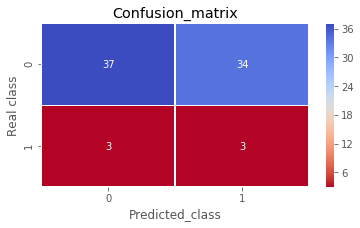


----------Classification Report------------------------------------
              precision    recall  f1-score   support

     average       0.93      0.52      0.67        71
    outliers       0.08      0.50      0.14         6

   micro avg       0.52      0.52      0.52        77
   macro avg       0.50      0.51      0.40        77
weighted avg       0.86      0.52      0.63        77



In [56]:
model(kNN_model_naive,os_data_X,X_Chi,os_data_y,y_Chi)

#### Decision Tree

the recall for this model is : 0.6666666666666666
TP 4
TN 42
FP 29
FN 2


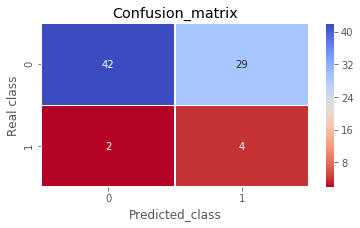


----------Classification Report------------------------------------
              precision    recall  f1-score   support

     average       0.95      0.59      0.73        71
    outliers       0.12      0.67      0.21         6

   micro avg       0.60      0.60      0.60        77
   macro avg       0.54      0.63      0.47        77
weighted avg       0.89      0.60      0.69        77



In [53]:
model(BestDT_naive,os_data_X,X_Chi,os_data_y,y_Chi)

#### Support Vector Machine

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


the recall for this model is : 1.0
TP 6
TN 11
FP 60
FN 0


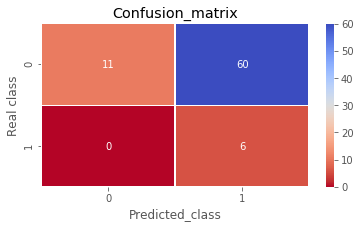


----------Classification Report------------------------------------
              precision    recall  f1-score   support

     average       1.00      0.15      0.27        71
    outliers       0.09      1.00      0.17         6

   micro avg       0.22      0.22      0.22        77
   macro avg       0.55      0.58      0.22        77
weighted avg       0.93      0.22      0.26        77



In [54]:
model(SVM_model_naive,os_data_X,X_Chi,os_data_y,y_Chi)

#### Losgistic Regression

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


the recall for this model is : 0.8333333333333334
TP 5
TN 17
FP 54
FN 1


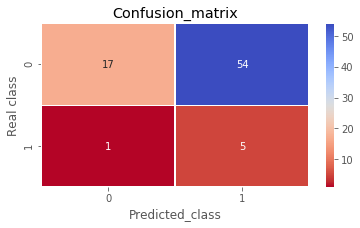


----------Classification Report------------------------------------
              precision    recall  f1-score   support

     average       0.94      0.24      0.38        71
    outliers       0.08      0.83      0.15         6

   micro avg       0.29      0.29      0.29        77
   macro avg       0.51      0.54      0.27        77
weighted avg       0.88      0.29      0.36        77



In [55]:
model(LR_model_naive,os_data_X,X_Chi,os_data_y,y_Chi)

### Oversampling: SMOTE

#### K Nearest Neighborhoods (KNN)

the recall for this model is : 0.3333333333333333
TP 2
TN 45
FP 26
FN 4


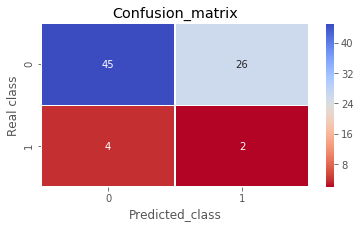


----------Classification Report------------------------------------
              precision    recall  f1-score   support

     average       0.92      0.63      0.75        71
    outliers       0.07      0.33      0.12         6

   micro avg       0.61      0.61      0.61        77
   macro avg       0.49      0.48      0.43        77
weighted avg       0.85      0.61      0.70        77



In [57]:
model(kNN_model_SMOTE,SMOTE_X,X_Chi,SMOTE_y,y_Chi)

#### Decision Tree

the recall for this model is : 0.8333333333333334
TP 5
TN 27
FP 44
FN 1


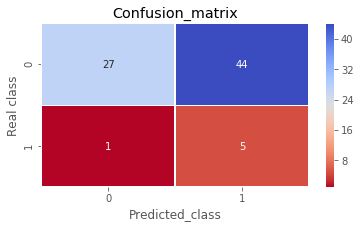


----------Classification Report------------------------------------
              precision    recall  f1-score   support

     average       0.96      0.38      0.55        71
    outliers       0.10      0.83      0.18         6

   micro avg       0.42      0.42      0.42        77
   macro avg       0.53      0.61      0.36        77
weighted avg       0.90      0.42      0.52        77



In [58]:
model(BestDT_SMOTE,SMOTE_X,X_Chi,SMOTE_y,y_Chi)

#### Support Vector Machine

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


the recall for this model is : 1.0
TP 6
TN 7
FP 64
FN 0


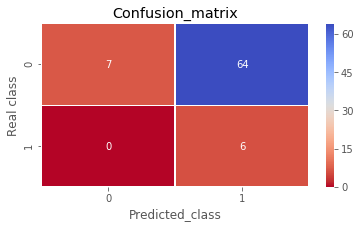


----------Classification Report------------------------------------
              precision    recall  f1-score   support

     average       1.00      0.10      0.18        71
    outliers       0.09      1.00      0.16         6

   micro avg       0.17      0.17      0.17        77
   macro avg       0.54      0.55      0.17        77
weighted avg       0.93      0.17      0.18        77



In [59]:
model(SVM_model_SMOTE,SMOTE_X,X_Chi,SMOTE_y,y_Chi)

#### Logistic Regression

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


the recall for this model is : 1.0
TP 6
TN 11
FP 60
FN 0


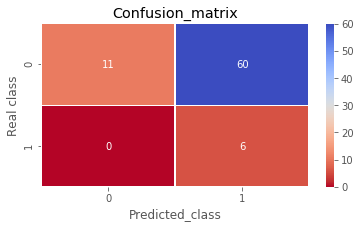


----------Classification Report------------------------------------
              precision    recall  f1-score   support

     average       1.00      0.15      0.27        71
    outliers       0.09      1.00      0.17         6

   micro avg       0.22      0.22      0.22        77
   macro avg       0.55      0.58      0.22        77
weighted avg       0.93      0.22      0.26        77



In [60]:
model(LR_model_SMOTE,SMOTE_X,X_Chi,SMOTE_y,y_Chi)

# Result and discussion <a name="result"></a>

Overall, our models do not perform well. If we accept a little loss in recall, let's say <b>recall = 0.83 at minimum</b>. Then the qualified models will be SVM model and logistic regression model trained by naive oversampled data, and decision tree model, SVM model and logistic regression model trained by SMOTE oversampled data. However, none of these models had satisfactory precision of predicting outliers. High recall of these models came at the cost of precision, which led to many false positive in prediction. Among the qualified models, the <b>highest precision is 0.10</b> from the decision tree model trained by SMOTE oversampled data, meaning that <b>there's only one neighborhood actually at high risk of credit card fraud out of ten neighborhoods predicted to be at high risk</b>. Although there's no relevant model for us to compare the precision of prediction, we find a [report](https://www.javelinstrategy.com/coverage-area/overcoming-false-positives-saving-sale-and-customer-relationship) stated that only 1 in 5 transactions declared as fraud by fraud detection model was truly fraud. Therefore, our models are not even close to this level of precision.

We go through the data we used and found out the following possible reasons responsible for the low precision of the model:

<b>1. Indistinct definition of credit card fraud:</b>
As I mentioned in the data section, the only clue we can define a crime as credit card fraud is through the category and description of each crime. However, compared to San Francisco data, the criminal description of Chicago data is not very informative for credit card fraud, as the description was just 'credit card fraud'. The term credit card fraud could stand for various form, which might not be equivalent to those of San Francisco data, contributing to the bad prediction of our models.

<b>2. Small number of training data:</b>
Small number of training data enhance the dilemma of overfitting and underfitting. Since the outliers of San Francisco data are few, split the data into training and test set could easily result in underfitting of the model. Therefore, we use the whole San Francisco data as training set. However, as we have seen, this might result in overfitting of the model. We can infer the overfitting from the overall bad recall of the KNN models (0.50 from naive oversampling and 0.33 from SMOTE oversampling). The credit card fraud rates of outlier meighborhoods in San Francisco have narrower range and higher value than those in Chicago (see boxplots above), therefore the outlier neighborhoods in Chicago with lower rates are <b>not 'near'</b> neighbors to the outlier neighborhoods in San Francisco.

## Future work <a name="future"></a>

Honestly, we have little to adjust for the problem of <b>indistinct definition of credit card fraud</b>. At best, we can contact the data owner to see if we can get more detailed description about the credit card fraud of Chicago data. For the problem of <b>small number of training data</b>, we can try to collect the whole credit card fraud data of USA to train the model, and use it to predict the risk of credit card fraud of neighborhoods in other country (e.g., Canada) to see if the larger amount of raw data solve the dilemma of overfitting and underfitting.